## Importing Libraries

In [2]:
import numpy as np
import pandas as pd

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn

import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline

from torch import optim

### Using a PyTorch Dataset
Loading CIFAR-10 dataset from `torchvision.datasets`, batch_size >= 16.

In [3]:
# code here
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=4)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                          shuffle=True, num_workers=4)

print(len(trainset), len(testset))
print(len(trainloader), len(testloader))

100%|██████████| 170498071/170498071 [00:02<00:00, 81766117.63it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified
50000 10000
3125 625


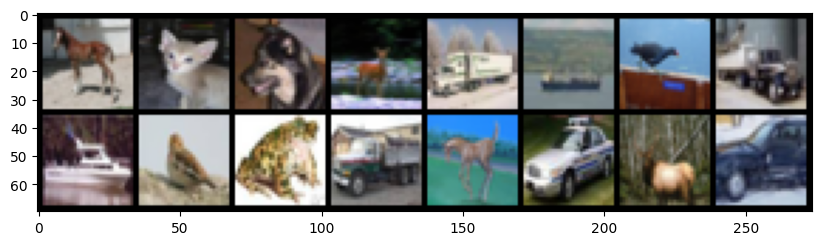

In [4]:
# let's have a look at the dataset
def imshow(img):
    img = img #/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# print(images.shape)
# print(labels.shape)
# print()

# show images
imshow(torchvision.utils.make_grid(images))

## Comparing MLP, CNN-MLP combination, CNN
### Defined 3 Models for Auto-Encoder
1. MLP-only model
2. CNN-MLP combination model
3. CNN-only model

In all the models, encoder and decoder should be consisting of $3$ layers each, and the encoder should be giving a flattened representation of size $32$.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MLPAutoEncoder(nn.Module):
    def __init__(self):
        super(MLPAutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*32*32, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 32),
        )
        self.decoder = nn.Sequential(
            # Write your code here
          # fully convolutional layers and connected layer
            nn.Linear(32, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3*32*32),
            nn.Unflatten(1, (3, 32, 32)),
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

class ComboAutoEncoder(nn.Module):
    def __init__(self):
        super(ComboAutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 4, stride=2, padding=1), # 3x32x32 -> 8x16x16
            nn.ReLU(),
            nn.Conv2d(8 ,12, 7, stride=1, padding=0), # 8x16x16 -> 12*10*10
            nn.ReLU(),
            nn.Flatten(), # 12*10*10 -> 1200
            nn.Linear(12*10*10, 32), # 1200 -> 32
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 12*10*10), # 32 -> 1200
            nn.Unflatten(1, (12,10,10)), # 1200 -> 12*10*10
            nn.ConvTranspose2d(12 ,8, 7, stride=1, padding=0), # 12*10*10 -> 8x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, 4, stride=2, padding=1), # 8x16x16 -> 3x32x32
            nn.Sigmoid(),
          )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

class CNNAutoEncoder(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1), # 3x32x32 -> 12x16x16
            nn.ReLU(),
            nn.Conv2d(12 ,24, 8, stride=2, padding=0), # 12x16x16 -> 24*5*5
            nn.ReLU(),
            nn.Conv2d(24, 8, 4, stride=1, padding=0), # 24*5*5 -> 8*2*2
            nn.ReLU(),
            nn.Flatten(), # 8*2*2 -> 32
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (8, 2, 2)), # 32 -> 8*2*2
            nn.ConvTranspose2d(8, 24, 4, stride=1, padding=0), # 8*2*2 -> 24*5*5
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 8, stride=2, padding=0), # 24*5*5 -> 12x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), # 12x16x16 -> 3x32x32
            nn.Sigmoid(),
          )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

## Using MSELoss, training all the models and analyse results

In [6]:
from tqdm.auto import tqdm
def calc(model, data):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    epochs = []
    losses = []
    for epoch in tqdm(range(10)):
        epochs.append(epoch+1)

        _loss = 0
        for i, (inputs, _) in enumerate(data, 0):

            inputs = inputs.to(device)

            # Forward pass and loss calculation
            encoded, outputs = model(inputs)
            loss = criterion(outputs, inputs)

            # Backpropogating gradient of loss
            optimizer.zero_grad()
            loss.backward()

            # Updating parameters(weights and bias)
            optimizer.step()

            _loss += loss.item()

        losses.append(_loss / len(data))
        print(f'epoch = {epoch+1},\tloss = {_loss / len(data)}')
        # print("Epoch{}, Training loss:{}".format(epoch, loss_ / len(train_loader)))

    print("Model trained...")
    return model, losses

def visuvalization(model, data):
    # get some random testing images
    dataiter = iter(data)
    images, labels = next(dataiter)

    # print('Original Image: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
    print("Original image")
    imshow(torchvision.utils.make_grid(images))

    images = Variable(images).cuda()

    print("Reconstructed image")
    decoded_imgs = model(images)[1]
    imshow(torchvision.utils.make_grid(decoded_imgs.data.cpu()))


---MLPAutoEncoder---


  0%|          | 0/10 [00:00<?, ?it/s]

epoch = 1,	loss = 0.026040846651792526
epoch = 2,	loss = 0.019986580180823804
epoch = 3,	loss = 0.017267055581510066
epoch = 4,	loss = 0.016498524525761605
epoch = 5,	loss = 0.01584982765048742
epoch = 6,	loss = 0.015389326113462448
epoch = 7,	loss = 0.015048643349409103
epoch = 8,	loss = 0.014870391626954079
epoch = 9,	loss = 0.014608371039330959
epoch = 10,	loss = 0.014486132887601852
Model trained...
Original image


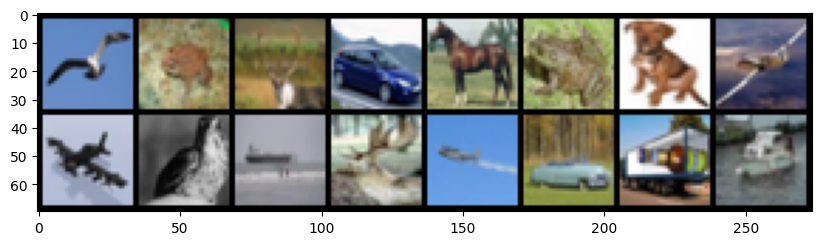

Reconstructed image


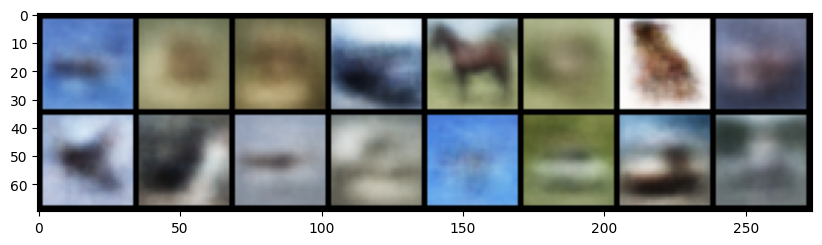

In [7]:
# code here
from torch import optim

print("---MLPAutoEncoder---")
model = MLPAutoEncoder().to(device)
model, mlpLosses = calc(model, trainloader)
visuvalization(model, testloader)

---ComboAutoEncoder---


  0%|          | 0/10 [00:00<?, ?it/s]

epoch = 1,	loss = 0.01713995377063751
epoch = 2,	loss = 0.01308727801322937
epoch = 3,	loss = 0.012828586201667786
epoch = 4,	loss = 0.012700164144039154
epoch = 5,	loss = 0.01258579192996025
epoch = 6,	loss = 0.012492906194478274
epoch = 7,	loss = 0.012441629469692708
epoch = 8,	loss = 0.012386992022544145
epoch = 9,	loss = 0.012329515578895807
epoch = 10,	loss = 0.012291517728567123
Model trained...
Original image


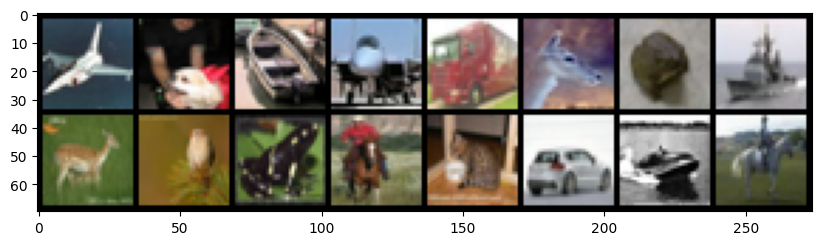

Reconstructed image


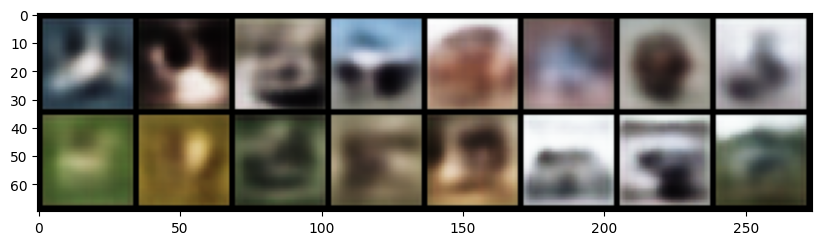

In [8]:
print("---ComboAutoEncoder---")
model = ComboAutoEncoder().to(device)
model, comboLosses = calc(model, trainloader)
visuvalization(model, testloader)

---CNNAutoEncoder---


  0%|          | 0/10 [00:00<?, ?it/s]

epoch = 1,	loss = 0.02321932558119297
epoch = 2,	loss = 0.01710199822217226
epoch = 3,	loss = 0.016086321188807488
epoch = 4,	loss = 0.015561277508735656
epoch = 5,	loss = 0.015252328967750072
epoch = 6,	loss = 0.015081875935196876
epoch = 7,	loss = 0.014944590319395065
epoch = 8,	loss = 0.014869002864956855
epoch = 9,	loss = 0.014793667840361594
epoch = 10,	loss = 0.01473630763888359
Model trained...
Original image


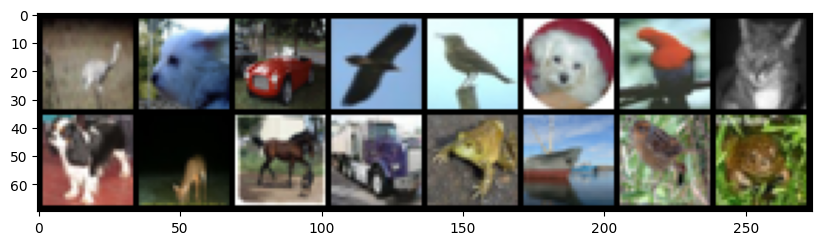

Reconstructed image


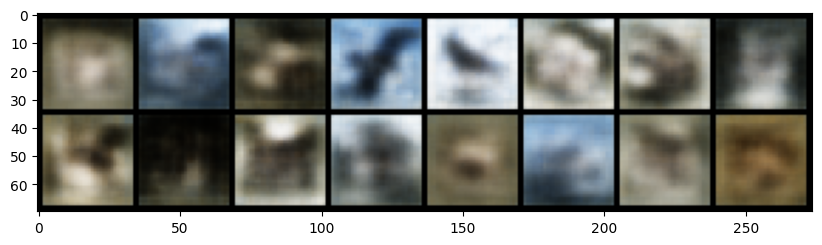

In [9]:
print("---CNNAutoEncoder---")
model = CNNAutoEncoder().to(device)
model, CNNLosses = calc(model, trainloader)
visuvalization(model, testloader)

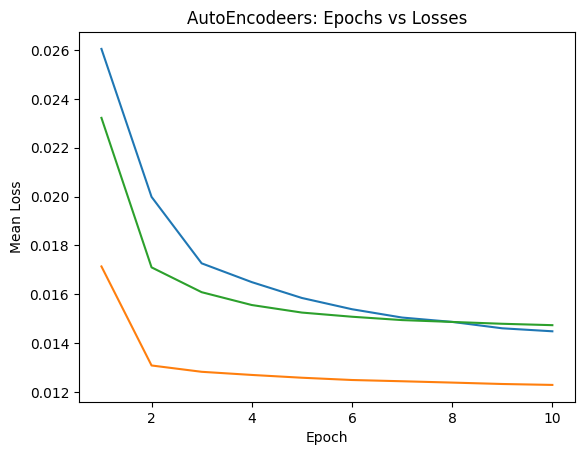

In [10]:
# analysis, plots and tabulations here
epochs = []
for i in range(10):
    epochs.append(i+1)

plt.xlabel('Epoch')
plt.ylabel('Mean Loss')
plt.title("AutoEncodeers: Epochs vs Losses")
plt.plot(epochs, mlpLosses, label = "MLPAutoEncoder")
plt.plot(epochs, comboLosses, label = "ComboAutoEncoder")
plt.plot(epochs, CNNLosses, label = "CNNAutoEncoder")
plt.show()

## Let's play with Representation Sizes
Inference: Found CNN to be more effective.

Playing with the following representation sizes:
1. 10
2. 32
3. 100
4. 1000

---CNNAutoEncoder for reprsentation size: 10---


  0%|          | 0/10 [00:00<?, ?it/s]

epoch = 1,	loss = 0.030604518138170243
epoch = 2,	loss = 0.027440953427553177
epoch = 3,	loss = 0.027232952191829682
epoch = 4,	loss = 0.026868648009300233
epoch = 5,	loss = 0.02614266624093056
epoch = 6,	loss = 0.02505352521777153
epoch = 7,	loss = 0.0249639977812767
epoch = 8,	loss = 0.024882644405961038
epoch = 9,	loss = 0.024809901083111763
epoch = 10,	loss = 0.024744831078350543
Model trained...
Original image


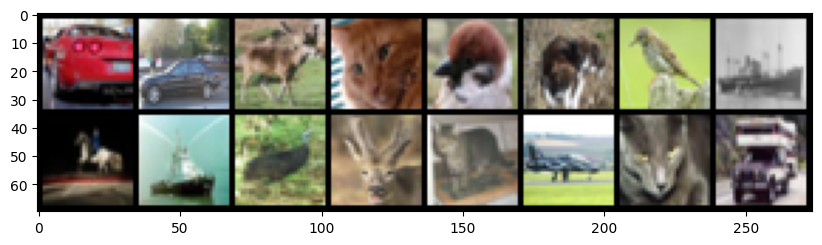

Reconstructed image


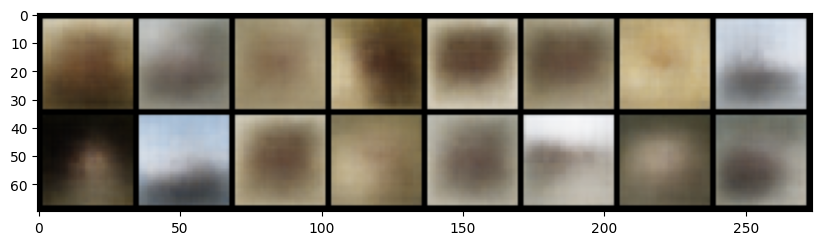

In [11]:
# code and analysis here
class CNNAutoEncoderFor10(nn.Module):
    def __init__(self):
        super(CNNAutoEncoderFor10, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1), # 3x32x32 -> 12x16x16
            nn.ReLU(),
            nn.Conv2d(12, 24, 8, stride=2, padding=0), # 12x16x16 -> 24*5*5
            nn.ReLU(),
            nn.Conv2d(24, 10, 5, stride=1, padding=0), # 24*5*5 -> 10*1*1
            nn.ReLU(),
            nn.Flatten(), # 10*1*1 -> 10
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (10, 1, 1)), # 10 -> 10*1*1
            nn.ConvTranspose2d(10, 24, 5, stride=1, padding=0), # 10*1*1  -> 24*5*5
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 8, stride=2, padding=0), # 24*5*5 -> 12x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), # 12x16x16 -> 3x32x32
            nn.Sigmoid(),
          )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


print("---CNNAutoEncoder for reprsentation size: 10---")
model = CNNAutoEncoderFor10().to(device)
calc(model, trainloader)
visuvalization(model, testloader)

---CNNAutoEncoder for reprsentation size: 32---


  0%|          | 0/10 [00:00<?, ?it/s]

epoch = 1,	loss = 0.023654268811047076
epoch = 2,	loss = 0.01728450343698263
epoch = 3,	loss = 0.0161902486500144
epoch = 4,	loss = 0.015670585730969907
epoch = 5,	loss = 0.015367834895849228
epoch = 6,	loss = 0.015153486151099205
epoch = 7,	loss = 0.015021544677019119
epoch = 8,	loss = 0.014916249710023402
epoch = 9,	loss = 0.014829096234738827
epoch = 10,	loss = 0.014743178781867027
Model trained...
Original image


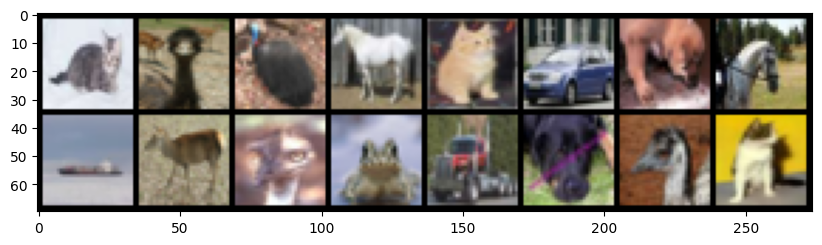

Reconstructed image


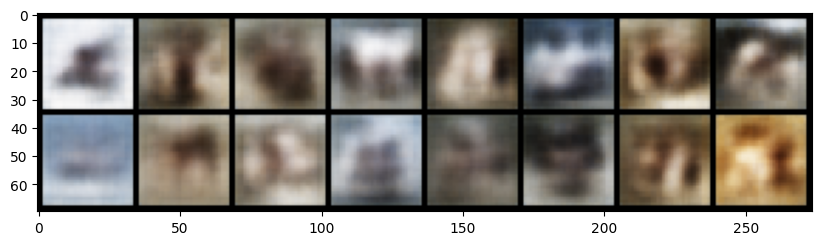

In [12]:
print("---CNNAutoEncoder for reprsentation size: 32---")
model = CNNAutoEncoder().to(device)
calc(model, trainloader)
visuvalization(model, testloader)

---CNNAutoEncoder for reprsentation size: 100---


  0%|          | 0/10 [00:00<?, ?it/s]

epoch = 1,	loss = 0.020201162381768226
epoch = 2,	loss = 0.01354610326230526
epoch = 3,	loss = 0.012311499249339103
epoch = 4,	loss = 0.011846732947826386
epoch = 5,	loss = 0.011575981434583663
epoch = 6,	loss = 0.011371343712508678
epoch = 7,	loss = 0.011224580748677253
epoch = 8,	loss = 0.01112976794078946
epoch = 9,	loss = 0.011059364142119884
epoch = 10,	loss = 0.01099430214613676
Model trained...
Original image


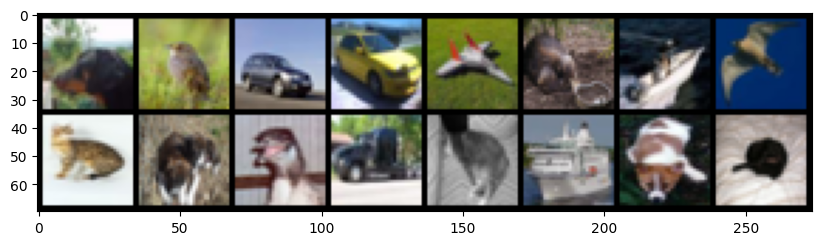

Reconstructed image


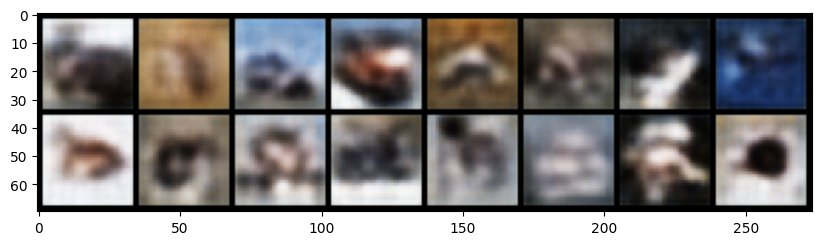

In [13]:

class CNNAutoEncoderFor100(nn.Module):
    def __init__(self):
        super(CNNAutoEncoderFor100, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1), # 3x32x32 -> 12x16x16
            nn.ReLU(),
            nn.Conv2d(12, 24, 8, stride=2, padding=0), # 12x16x16 -> 24*5*5
            nn.ReLU(),
            nn.Conv2d(24, 25, 4, stride=1, padding=0), # 24*5*5 -> 25*2*2
            nn.ReLU(),
            nn.Flatten(), # 25*2*2 -> 100
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (25, 2, 2)), # 100 -> 25*2*2
            nn.ConvTranspose2d(25, 24, 4, stride=1, padding=0), # 25*2*2 -> 24*5*5
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 8, stride=2, padding=0), # 24*5*5 -> 12x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), # 12x16x16 -> 3x32x32
            nn.Sigmoid(),
          )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

print("---CNNAutoEncoder for reprsentation size: 100---")
model = CNNAutoEncoderFor100().to(device)
calc(model, trainloader)
visuvalization(model, testloader)

---CNNAutoEncoder for reprsentation size: 1000---


  0%|          | 0/10 [00:00<?, ?it/s]

epoch = 1,	loss = 0.012497921455204487
epoch = 2,	loss = 0.006541953603774309
epoch = 3,	loss = 0.005517886883839965
epoch = 4,	loss = 0.00488269634000957
epoch = 5,	loss = 0.00419443243034184
epoch = 6,	loss = 0.0038388733103871344
epoch = 7,	loss = 0.0036172744346410035
epoch = 8,	loss = 0.0034416356661915778
epoch = 9,	loss = 0.0032787076618522406
epoch = 10,	loss = 0.0031513702458143234
Model trained...
Original image


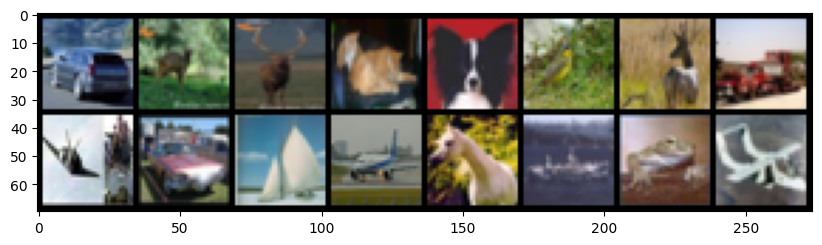

Reconstructed image


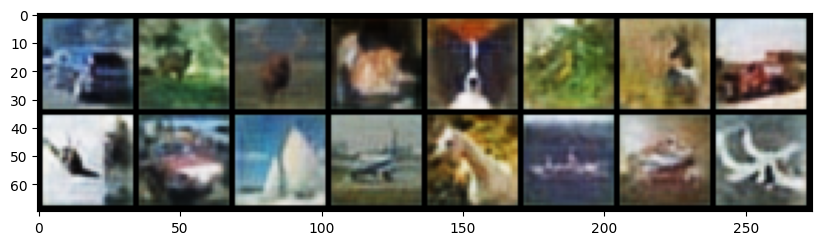

In [14]:
class CNNAutoEncoderFor1000(nn.Module):
    def __init__(self):
        super(CNNAutoEncoderFor1000, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1), # 3x32x32 -> 12x16x16
            nn.ReLU(),
            nn.Conv2d(12, 24, 5, stride=1, padding=0), # 12x16x16 -> 24*12*12
            nn.ReLU(),
            nn.Conv2d(24, 10, 3, stride=1, padding=0), # 24*12*12 -> 10*10*10
            nn.ReLU(),
            nn.Flatten(), # 10*10*10 -> 1000
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (10, 10, 10)), # 1000 -> 10*10*10
            nn.ConvTranspose2d(10, 24, 3, stride=1, padding=0), # 10*10*10 -> 24*12*12
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 5, stride=1, padding=0), # 24*12*12 -> 12x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), # 12x16x16 -> 3x32x32
            nn.Sigmoid(),
          )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

print("---CNNAutoEncoder for reprsentation size: 1000---")
model = CNNAutoEncoderFor1000().to(device)
calc(model, trainloader)
visuvalization(model, testloader)

##What about the number of layers?

Experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder can have a significant impact on its performance with CIFAR-10 dataset.

Playing with the following numbers of layers for encoder and decoder each:
1. 1
2. 3
3. 5
4. 10

---CNNAutoEncoder With 1 Layers---


  0%|          | 0/10 [00:00<?, ?it/s]

epoch = 1,	loss = 0.04588392692387104
epoch = 2,	loss = 0.0387369547945261
epoch = 3,	loss = 0.03794585319638252
epoch = 4,	loss = 0.03777487330496311
epoch = 5,	loss = 0.03772124172747135
epoch = 6,	loss = 0.037687632186412814
epoch = 7,	loss = 0.037683698210716245
epoch = 8,	loss = 0.037668089742064474
epoch = 9,	loss = 0.03767208926379681
epoch = 10,	loss = 0.037669574664235116
Model trained...
Original image


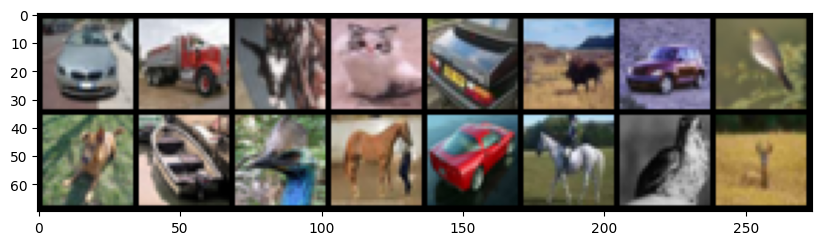

Reconstructed image


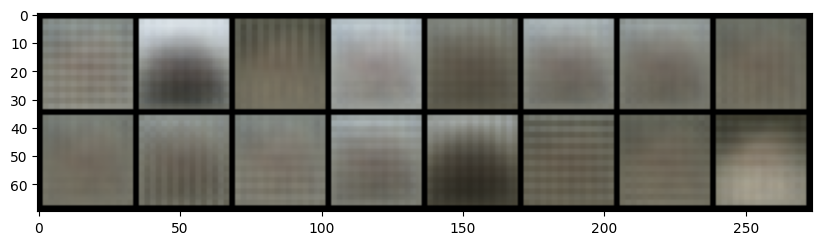

In [15]:
# code and analysis here
class CNNAutoEncoderFor1Layer(nn.Module):
    def __init__(self):
        super(CNNAutoEncoderFor1Layer, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 30, stride=2, padding=0), # 3x32x32 -> 8x2x2
            nn.ReLU(),
            nn.Flatten(), # 8*2*2 -> 32
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (8, 2, 2)), # 32 -> 8*2*2
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, 30, stride=2, padding=0), # 8*2*2 -> 3*32*32
            nn.Sigmoid(),
          )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

print("---CNNAutoEncoder With 1 Layers---")
model = CNNAutoEncoderFor1Layer().to(device)
calc(model, trainloader)
visuvalization(model, testloader)

---CNNAutoEncoder With 3 Layers---


  0%|          | 0/10 [00:00<?, ?it/s]

epoch = 1,	loss = 0.024299829078912736
epoch = 2,	loss = 0.01752830004155636
epoch = 3,	loss = 0.016818299935162068
epoch = 4,	loss = 0.016451877314150334
epoch = 5,	loss = 0.016143317241370678
epoch = 6,	loss = 0.015877014430761338
epoch = 7,	loss = 0.015585236310958862
epoch = 8,	loss = 0.0153987340092659
epoch = 9,	loss = 0.01526839179635048
epoch = 10,	loss = 0.015173035285174847
Model trained...
Original image


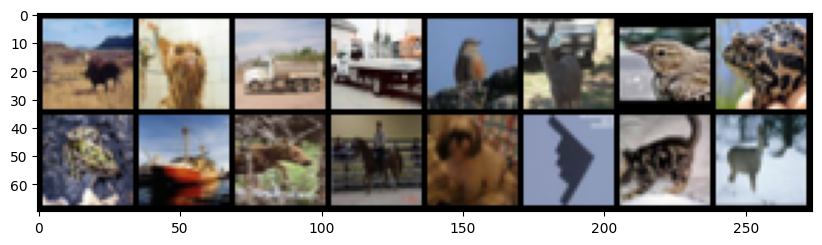

Reconstructed image


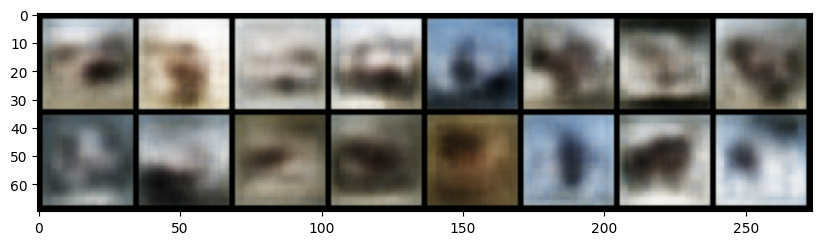

In [16]:
print("---CNNAutoEncoder With 3 Layers---")
model = CNNAutoEncoder().to(device)
calc(model, trainloader)
visuvalization(model, testloader)

---CNNAutoEncoder With 5 Layers---


  0%|          | 0/10 [00:00<?, ?it/s]

epoch = 1,	loss = 0.025973429306745528
epoch = 2,	loss = 0.017018402935266495
epoch = 3,	loss = 0.015090378428399562
epoch = 4,	loss = 0.014181814506947995
epoch = 5,	loss = 0.013699332576096058
epoch = 6,	loss = 0.013428000811636448
epoch = 7,	loss = 0.013265429722666741
epoch = 8,	loss = 0.013172756451368332
epoch = 9,	loss = 0.013103735980391502
epoch = 10,	loss = 0.013052367334365845
Model trained...
Original image


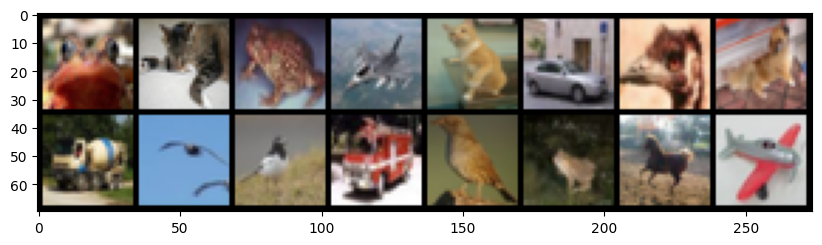

Reconstructed image


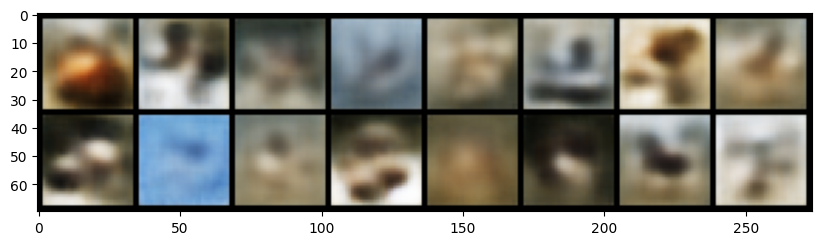

In [17]:
class CNNAutoEncoderFor5Layer(nn.Module):
    def __init__(self):
        super(CNNAutoEncoderFor5Layer, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1), # 3x32x32 -> 12x16x16
            nn.ReLU(),
            nn.Conv2d(12, 16, 5, stride=1, padding=0), # 12x16x16 -> 16*12*12
            nn.ReLU(),
            nn.Conv2d(16 ,20, 5, stride=1, padding=0), # 16*12*12 -> 20*8*8
            nn.ReLU(),
            nn.Conv2d(20, 24, 4, stride=2, padding=1), # 20*8*8 -> 24*4*4
            nn.ReLU(),
            nn.Conv2d(24, 8, 3, stride=1, padding=0), # 24*4*4 -> 8*2*2
            nn.ReLU(),
            nn.Flatten(), # 8*2*2 -> 32
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (8, 2, 2)), # 32 -> 8*2*2
            nn.ReLU(),
            nn.ConvTranspose2d(8, 24, 3, stride=1, padding=0), # 8*2*2 -> 24*4*4
            nn.ReLU(),
            nn.ConvTranspose2d(24, 20, 4, stride=2, padding=1), # 24*4*4 -> 20*8*8
            nn.ReLU(),
            nn.ConvTranspose2d(20, 16, 5, stride=1, padding=0), # 20*8*8 -> 16*12*12
            nn.ReLU(),
            nn.ConvTranspose2d(16, 12, 5, stride=1, padding=0), # 16*12*12 -> 12*16*16
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), # 12*16*16 -> 3*32*32
            nn.Sigmoid(),
          )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


print("---CNNAutoEncoder With 5 Layers---")
model = CNNAutoEncoderFor5Layer().to(device)
calc(model, trainloader)
visuvalization(model, testloader)

---CNNAutoEncoder With 10 Layers---


  0%|          | 0/10 [00:00<?, ?it/s]

epoch = 1,	loss = 0.062119231687784195
epoch = 2,	loss = 0.06205306656122208
epoch = 3,	loss = 0.06204807844519615
epoch = 4,	loss = 0.06204114226937294
epoch = 5,	loss = 0.062030917369127275
epoch = 6,	loss = 0.06202932902693749
epoch = 7,	loss = 0.062023154538869855
epoch = 8,	loss = 0.06202077348828316
epoch = 9,	loss = 0.062024963717460635
epoch = 10,	loss = 0.06202307736754417
Model trained...
Original image


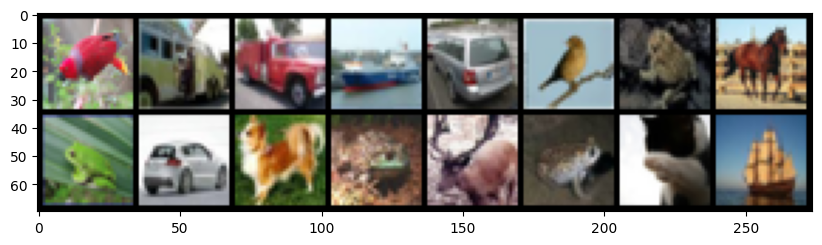

Reconstructed image


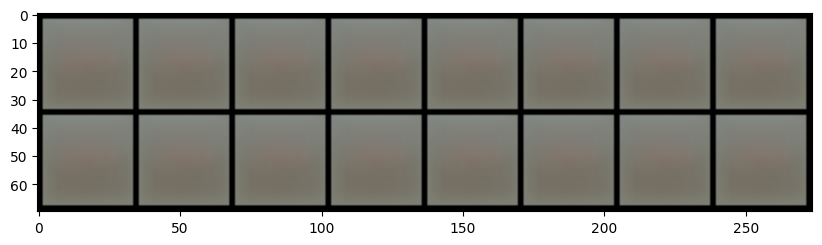

In [35]:
class CNNAutoEncoderFor10Layer(nn.Module):
    def __init__(self):
        super(CNNAutoEncoderFor10Layer, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, 5, stride=1, padding=0), # 3x32x32 -> 6*28*28
            nn.ReLU(),
            nn.Conv2d(6, 8, 5, stride=1, padding=0), # 6*28*28-> 8*24*24
            nn.ReLU(),
            nn.Conv2d(8, 10, 5, stride=1, padding=0), # 8*24*24-> 10*20*20
            nn.ReLU(),
            nn.Conv2d(10, 12, 5, stride=1, padding=0), # 10*20*20 -> 12*16*16
            nn.ReLU(),
            nn.Conv2d(12, 16, 3, stride=1, padding=0), # 12*16*16 -> 16*14*14
            nn.ReLU(),
            nn.Conv2d(16, 12, 3, stride=1, padding=0), # 16*14*14 -> 12*12*12
            nn.ReLU(),
            nn.Conv2d(12, 10, 3, stride=1, padding=0), # 12*12*12 -> 10*10*10
            nn.ReLU(),
            nn.Conv2d(10, 8, 4, stride=2, padding=1), # 10*10*10 -> 8*5*5
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, stride=2, padding=1), # 8*5*5 -> 8*3*3
            nn.ReLU(),
            nn.Conv2d(8, 8, 2, stride=1, padding=0), # 8*3*3 -> 8*2*2
            nn.ReLU(),
            nn.Flatten(), # 8*2*2 -> 32
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (8, 2, 2)), # 32 -> 8*2*2
            nn.ReLU(),
            nn.ConvTranspose2d(8, 8, 2, stride=1, padding=0), # 8*2*2 -> 8*3*3
            nn.ReLU(),
            nn.ConvTranspose2d(8, 8, 3, stride=2, padding=1), # 8*3*3 -> 8*5*5
            nn.ReLU(),
            nn.ConvTranspose2d(8, 10, 4, stride=2, padding=1), # 8*5*5-> 10*10*10
            nn.ReLU(),
            nn.ConvTranspose2d(10, 12, 5, stride=1, padding=1), # 10*10*10-> 12*12*12
            nn.ReLU(),
            nn.ConvTranspose2d(12, 16, 5, stride=1, padding=1), # 12*12*12 -> 16*14*14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 12, 5, stride=1, padding=1), # 16*14*14 -> 12*16*16
            nn.ReLU(),
            nn.ConvTranspose2d(12, 10, 5, stride=1, padding=0), # 12*16*16 -> 10*20*20
            nn.ReLU(),
            nn.ConvTranspose2d(10, 8, 5, stride=1, padding=0), # 10*20*20 -> 8*24*24
            nn.ReLU(),
            nn.ConvTranspose2d(8, 6, 5, stride=1, padding=0), # 8*24*24 -> 6*28*28
            nn.ReLU(),
            nn.ConvTranspose2d(6, 3, 7, stride=1, padding=1), # 6*28*28 -> 3*32*32
            nn.Sigmoid(),
          )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


print("---CNNAutoEncoder With 10 Layers---")
model = CNNAutoEncoderFor10Layer().to(device)
calc(model, trainloader)
visuvalization(model, testloader)

### Explaination time!
Please write a short-essay explaining what AutoEncoder does, how it is different from other data-representation methods like PCA, t-SNE and Variational AutoEncoders. Also tell what were your take-outs from this experiment.

In [19]:
# explainations here
# CNN: CNN are neural network generally used in deep learning for image and video recognition, natural language processing, and other tasks involving structured inputs.
# It consists of convolutional layers, pooling layers and fully connected layers. Convoluational layers use filters to convolve over the input data and extract local features
# such as edges and corners. Fully connected layers are added at the end of the network.

# In my case I havent used pooling layers because I was getting sufficiently less loss without using those as well.

# Autoencoders: Autoencoders are a type of neural network that can be used for unsupervised learning. It consists of two components an encoder and a decoder.
# The encoder takes an input and maps it to a lower-dimensional, while the decoder takes this lower-dimensional representation and maps it back to the original input space.
# The encoder and decoder are trained together in an end-to-end manner to minimize the reconstruction error/losses between the input and the output.

# Autoencoders are often used for image compression, where the encoder compresses the image into a smaller representation and the decoder reconstructs
# the original image from this representation. This is done multiple epochs anf finetuned. By doing so, autoencoders can learn important features or patterns in the data.
# Whereas in PCA we learn important features by capturing the largest variance in the data using orthogonal transformations.
# The difference between both the methods is just the different way of learning important features and both performs differently in different use cases
# In case of image compressions Autoencoders are found to be more effective!

## Part 3: Siamese Networks
Siamese networks are useful for comparing and finding similarities between two inputs. The inputs from identical encoder sub-networks will be given as an input to a CNN(best performing based on above experimenting) and the prediction will be given as output of a Sigmoid function.

### Defining a Siamese Network

In [27]:
# sample.
class SiameseNetwork(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder1 = encoder
        self.encoder2 = encoder
        self.decoder = nn.Sequential(
            nn.Linear(2048,1024),
            # whatever
        )

    def forward(self, x1, x2):
        encoded1 = self.encoder1(x1)
        encoded2 = self.encoder2(x2)
        return (encoded1,encoded2)

    def differentiate(self, x1_embedding, x2_embedding):
        x = torch.cat([x1_embedding,x2_embedding],dim=1)
        return self.decoder(x)


### Step two: Define the following three losses:
1. TripletLoss
2. ContrastiveLoss
3. Regularized Cross Entropy Loss

In [28]:
# TripletLoss defined as an example
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Compute the distances between the anchor, positive, and negative examples
        distance_pos = F.pairwise_distance(anchor, positive, p=2)
        distance_neg = F.pairwise_distance(anchor, negative, p=2)
        # Compute the triplet loss using the margin
        loss_triplet = torch.mean(torch.clamp(distance_pos - distance_neg + self.margin, min=0.0))
        return loss_triplet

In [23]:
# code here


### Train the Siamese network...
... and write a function that takes 2 inputs and outputs whether they belong to the same class or not. Plot and share the results of the function. The results should contain both successful results, i.e. classification as 'same' for inputs belonging to the same class and classification as 'not-same' for inputs belonging to different classes, as well as some unsuccessful results (that gives the wrong output than expected).
Provide an explanation of why the unsuccessful results might occur.

In [24]:
# code and analysis here